# <center>Using Large Language Models</center>

In this notebook we will demonstrate a new means of solving a common analysis/ data science task: understanding and labeling text. The tasks of summarizing and labeling texts are present in many analyst tasks and are an area where there has been an explosion of recent work in AI on. For this notebook, we are going to be leveraging some of the recent work in [Large Language Models (LLMs)](https://machinelearningmastery.com/what-are-large-language-models/) to solve these ML challenges. 

For this notebook, we will cover the following:
1. Installing packages and setting up the environment
2. Creating a data set
3. Summarizing and describing a corpus of text
4. Zero-shot text labeling
5. Using Prompt Engineering for more complex analyses of text data

----Addendum Section-----

6. Additional ways (i.e. prompting) to summarize and describe text

# 1. Import necessary Packages and Set up the Environment
- Import necessary packages, most especially [HuggingFace](https://huggingface.co/), Torch, and [LangChain](https://python.langchain.com/en/latest/index.html)
- we will also import and install Google's API in order to get some data related to YouTube Comments
- finally, we will set up any OpenAI keys for demonstrating working with API-based LLMs, like GPT.

In [ ]:
! pip install google-api-python-client
! pip install langchain --user
! pip install openai --user
! pip install bertopic
# The following are for getting certain LLMs to work
! pip install einops
! pip install tiktoken

In [1]:
import os, re, numpy as np, pandas as pd
from collections import Counter
from scipy import stats
from hdbscan import HDBSCAN
import umap
import openai
from nltk.sentiment.vader import SentimentIntensityAnalyzer

from bertopic import BERTopic
from bertopic.representation import MaximalMarginalRelevance
from bertopic.representation import LangChain
from bertopic.representation import TextGeneration

from sentence_transformers  import SentenceTransformer
from transformers import pipeline
import torch

from googleapiclient.discovery import build

from langchain import OpenAI, PromptTemplate, LLMChain, HuggingFacePipeline, FewShotPromptTemplate
from langchain.llms import AzureOpenAI
from langchain.chains.summarize import load_summarize_chain
from langchain.chains.question_answering import load_qa_chain
from langchain.docstore.document import Document
from langchain.chains.mapreduce import MapReduceChain
from langchain.text_splitter import RecursiveCharacterTextSplitter

from matplotlib import pyplot as plt
import seaborn as sns

/usr/local/lib/python3.10/dist-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/usr/local/lib/python3.10/dist-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/usr/local/lib/python3.10/dist-packages/umap/distances.py:1086: NumbaDeprecationWarning: The 'nopython' keyword argume

In [2]:
# import OpenAI Key, if you have one and want to use OpenAI's LLMs

with open("personal_openai_key.txt") as f:
    open_api_key = f.read()
    
os.environ["OPENAI_API_KEY"] = open_api_key

In [3]:
# Use OpenAI from Azure, for those that have Azure Credits

with open("aci_openai_credentials.txt") as f:
    open_api_base, open_api_key = f.read().split("\n")

os.environ["OPENAI_API_TYPE"] = "azure"
os.environ["OPENAI_API_VERSION"] = "2022-12-01"
os.environ["OPENAI_API_BASE"] = open_api_base
os.environ["OPENAI_API_KEY"] = open_api_key

# 2. Create a data set

For this demonstration, we are going to do an analysis of social media data. More specifically, we want to look at the comments on a YouTube video; imagine that you are a public affairs/social media analyst and want to get 'reflections' on a recent recruiting campaign video. We want to understand what is being talked about in the comments of the YouTube video and how the video is being received. As a follow on, we want to be able to classify those comments into a series of custom labels, which has the potential of being a machine learning task.

The tasks that we will need to do in this section are:

- import comments from YouTube videos. The following functions are for scraping the comments of a youtube video, given the video id
- look at some examples

In [4]:
def get_video_comments(video_id, api_key):
    """Retrieve comments for a YouTube video.

    This function retrieves comments for a YouTube video specified by the given video ID using the YouTube Data API.
    
    Parameters:
    video_id (str): The ID of the YouTube video for which to retrieve comments.
    api_key (str): The API key to access the YouTube Data API.

    Returns:
    list: A list of dictionaries containing information about each comment. Each dictionary has the following keys:
        - 'id' (str): The ID of the comment.
        - 'comment' (str): The text content of the comment.
        - 'author' (str): The display name of the comment's author.
        - 'author_channel' (str): The channel ID of the comment's author.
        - 'like_count' (int): The number of likes on the comment.
        - 'published_at' (str): The publish date and time of the comment.
        - 'conversation_id' (str): The ID of the comment thread or conversation.
    
    """
    # empty list for storing reply
    replies = []
 
    # creating youtube resource object
    youtube = build('youtube', 'v3',
                    developerKey=api_key)
 
    # retrieve youtube video results
    video_response=youtube.commentThreads().list(
        part='snippet',
        maxResults=100,
        videoId=video_id
    ).execute()
 
    # iterate video response
    results = []
    while video_response:
       
        # extracting required info
        # from each result object
        for item in video_response['items']:
           
            datum = {}
            datum['id'] = item['id']
            datum['comment'] = item['snippet']['topLevelComment']['snippet']['textOriginal']
            datum['author'] = item['snippet']['topLevelComment']['snippet']['authorDisplayName']
            datum['author_channel'] = item['snippet']['topLevelComment']['snippet']['authorChannelId']['value']
            datum['like_count'] = item['snippet']['topLevelComment']['snippet']['likeCount']
            datum['published_at'] = item['snippet']['topLevelComment']['snippet']['publishedAt']
            datum['coversation_id'] = item['id']
            results.append(datum)
            if item['snippet']['totalReplyCount'] > 0:
                results.extend(get_all_top_level_comment_replies(item['id'], [], None)) 
 
        # Again repeat
        if 'nextPageToken' in video_response:
            video_response = youtube.commentThreads().list(
                    part = 'snippet',
                    pageToken = video_response['nextPageToken'],
                    videoId = video_id
                ).execute()
        else:
            return results

In [5]:
def get_all_top_level_comment_replies(top_comment_id, replies, token):
    
    # creating youtube resource object
    youtube = build('youtube', 'v3',
                    developerKey=api_key)
    
    replies_response=youtube.comments().list(part='snippet',
                                               maxResults=100,
                                               parentId=top_comment_id,
                                               pageToken=token).execute()

    for item in replies_response['items']:
        datum = {}
        datum['id'] = item['id']
        datum['comment'] = item['snippet']['textOriginal']
        datum['author'] = item['snippet']['authorDisplayName']
        datum['author_channel'] = item['snippet']['authorChannelId']['value']
        datum['like_count'] = item['snippet']['likeCount']
        datum['published_at'] = item['snippet']['publishedAt']
        datum['coversation_id'] = top_comment_id
        replies.append(datum)

    if "nextPageToken" in replies_response: 
        return get_all_top_level_comment_replies(top_comment_id, replies, replies_response['nextPageToken'])
    else:
        return replies

In [6]:
# Possible YouTube videos that we will look at for Analysis

video_id = "Lwx-2R9swDg" # Be All You Can Be - U.S. Army's new brand trailer - U.S. Army
#video_id = "-ZMzfihqOkQ" # What Army Snipers Go Through At Sniper School - insider business
#video_id = "nV8UZJNBY6Y" # Adele - The Final Carpool Karaoke
#video_id = "kLMMxgtxQ1Y" # GOP- Beat Biden AI-generated images

If scraping new data run the following...

In [64]:
with open("youtube_credentials.txt") as f:
    api_key = f.read()

In [8]:
comments = get_video_comments(video_id, api_key)

In [9]:
comments_df = pd.DataFrame(comments)

In [10]:
# save data
comments_df.to_csv("video_comments_"+video_id+".csv")

... Else just read in previously scraped data

In [7]:
# load data
comments_df = pd.read_csv("video_comments_"+video_id+".csv", index_col=0)

Now, let's have a quick look at what we got back form scraping comments

In [8]:
comments_df.shape

(5086, 7)

In [9]:
comments_df.head()

,id,comment,author,author_channel,like_count,published_at,coversation_id
0,UgyZqW0x5zhxhYxWj0F4AaABAg,What will would come out with and say about th...,Shea Synott,UCq9iU_VTUeCnVKnr_vdOwXw,0,2023-05-28T23:18:11Z,UgyZqW0x5zhxhYxWj0F4AaABAg
1,UgzN65JCJ-_xTi48zJF4AaABAg,We don't need anymore imbred Ukrainian soldier...,Shea Synott,UCq9iU_VTUeCnVKnr_vdOwXw,0,2023-05-27T07:44:16Z,UgzN65JCJ-_xTi48zJF4AaABAg
2,UgzOjmN9_qlyirQ6QCB4AaABAg,If you are dumb enough to join the military be...,Mike Stanton,UCsQQR5LeDxNgmV1Gzp9roGg,1,2023-05-26T22:40:04Z,UgzOjmN9_qlyirQ6QCB4AaABAg
3,UgzXfU7YSB65CxFeJSF4AaABAg,"""Thanks to the terrible power of our Internati...",theycallme_nightmaster,UC6QQIz9FS03tGZDUieRiRRg,2,2023-05-26T09:33:48Z,UgzXfU7YSB65CxFeJSF4AaABAg
4,Ugxu-OImhl2ZP2zgWUR4AaABAg,Yooooo... Lol I went to Basic at Ft. Leonardwo...,Mr. Grown Gamer,UCidfBxbswcgs7Y1aJsjZMfQ,0,2023-05-26T05:48:29Z,Ugxu-OImhl2ZP2zgWUR4AaABAg


# 3. Preprocess the Text

Before diving into the machine learning-based analysis of the text, we first need to do some light text preprocessing. It would also be good to visualize all of the comments to see if there are any patterns or outliers in the text. So, in this section we will do the following:

- remove URLs from text, as the generally don't provide any semantic information. Removing mentions (i.e.`@`) can also help for this as well.
- visualize the comments to see if there are any distinct patterns or clusters in the data using embeddings and a dimensionality reduction technique, in this case [UMAP](https://umap-learn.readthedocs.io/en/latest/).

In [10]:
def process_text(text): 
    
    text = text.replace("&amp;", "and").replace("&gt;", ">").replace(
        "&lt;", "<")
    
    #remove urls
    text = re.sub(r'http\S+|www\S+', "", text)
    
    #change new lines into spaces
    text = re.sub("\n", " ", text)
    text = re.sub("\n\n", " ", text)
    
    return text

In [11]:
# preprocess the text to remove mentions and tame the newline characters

comments_df['clean_comment'] = comments_df["comment"].apply(lambda x : process_text(x))

In [13]:
# Create vector embeddings of the comments

embedding_model = SentenceTransformer('sentence-transformers/distiluse-base-multilingual-cased-v2', device='cuda:0')
# embedding_model = SentenceTransformer("all-MiniLM-L6-v2")

comments_df['embedding'] = comments_df["clean_comment"].apply(lambda x : embedding_model.encode(x))

In [18]:
# Reduce the dimensionality of the embeddings so that we can visualize them

X_vis = umap.UMAP(n_neighbors =30, n_components=2, metric="cosine", min_dist=0.0).fit_transform(np.array(comments_df['embedding'].values.tolist()))
vis_df = pd.DataFrame(X_vis, columns=['x', 'y'])

<Axes: xlabel='x', ylabel='y'>

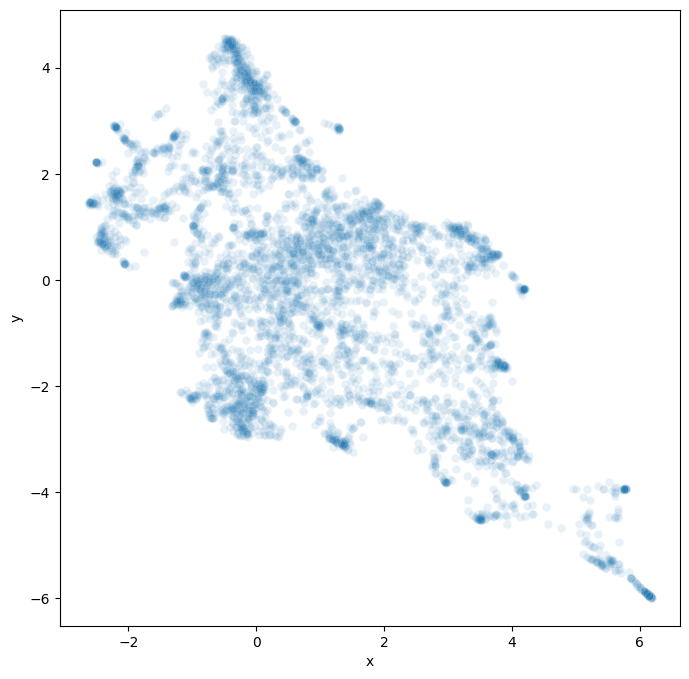

In [19]:
# visualize the dimensionality-reduced embeddings of the text

plt.figure(figsize=(8,8))
sns.scatterplot(data=vis_df, x='x', y='y', alpha=0.1)

In the previous cells, we did a couple of things. First, we cleaned the data. Second, we used [Sentence Transformers](https://www.sbert.net/) to embed each of the comments into a vector space. Then, we reduced the dimensionality of those vectors into 2-d so that we could visualize all the comments. The use of pre-trained sentence embeddings is the first use of our no-train machine learning models. In this case, we are using a pre-trained machine learning model to map text into a vector (i.e. embed the data).

From this initial look at the data, there are some more regions of clusteriness - but no clearly separated clusters - and no clear outlier comments that we need to drop from the data set. 

# 4. Describe the Comments

To describe the comments, we want to do a two-step procedure: group text together by "topics" and describe those topics. This will be the second use of no-train machine learning models.
- use [BERTopic](https://maartengr.github.io/BERTopic/index.html) to group together like articles, since any given corpus of text will often feature multiple comments
- use a ['representation'](https://maartengr.github.io/BERTopic/getting_started/representation/representation.html) layer with BERTopic to describe the different topics. This representation layer can be a number of things, including text summarization by an LLM.

Note that BERTopic has _a lot_ of variations that one can do, to include [incorporating](https://maartengr.github.io/BERTopic/index.html#variations) labels into the topic modeling, or text clustering, procedure.

In [14]:
# Sepcify the topic modeling and summarization

topic_model = BERTopic(
    embedding_model=embedding_model,
    umap_model = umap.UMAP(n_neighbors=30, n_components=50, min_dist=0.0, metric='cosine'),
    hdbscan_model = HDBSCAN(min_cluster_size=int(len(comments_df)/100), metric='euclidean', cluster_selection_method='eom', prediction_data=True),
    #nr_topics= "auto",
    representation_model = MaximalMarginalRelevance(diversity=0.3)
)

In [15]:
topics, probs = topic_model.fit_transform(comments_df["clean_comment"])

In [16]:
topic_model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,1434,-1_and_for_they_this,"[and, for, they, this, we, not, all, my, your,...",[@Kevin Johnston Stalin underestimated his own...
1,0,1491,0_and_for_army_this,"[and, for, army, this, white, all, military, y...","[If you are White and join this, remember that..."
2,1,464,1_israel_for_jews_can,"[israel, for, jews, can, fight, israeli, all, ...","[I will not die for Israel, I will not die for..."
3,2,429,2_maxwell_your_what_know,"[maxwell, your, what, know, like, williams, mr...","[@The Gem don't do it man, everyone I know wh..."
4,3,326,3_oy_shut_lol_goy,"[oy, shut, lol, goy, what, ok, fucking, well, ...","[Shut it down THE GOYIM KNOW, The goyim know. ..."
5,4,296,4_russia_ukraine_china_we,"[russia, ukraine, china, we, russian, with, ru...",[​​@I Stand With Russia (Z O V) Do you actuall...
6,5,208,5_zogbot_lmfao_bankers_110,"[zogbot, lmfao, bankers, 110, correct, number,...","[zogbot, Zogbot, Zogbot lmao]"
7,6,130,6_comments_section_these_hope,"[comments, section, these, hope, here, you, re...","[Best comments section ever, the comments 🤣🤣🤣🤣..."
8,7,114,7_can_all_for_cough,"[can, all, for, cough, white, always, blessing...","[Be All You Can Be!, Be all you can be., Be al..."
9,8,109,8_and_maxwell_melting_country,"[and, maxwell, melting, country, your, english...","[​@Maxwell.Vondeen melting pot lmao, I live in..."


<Axes: xlabel='x', ylabel='y'>

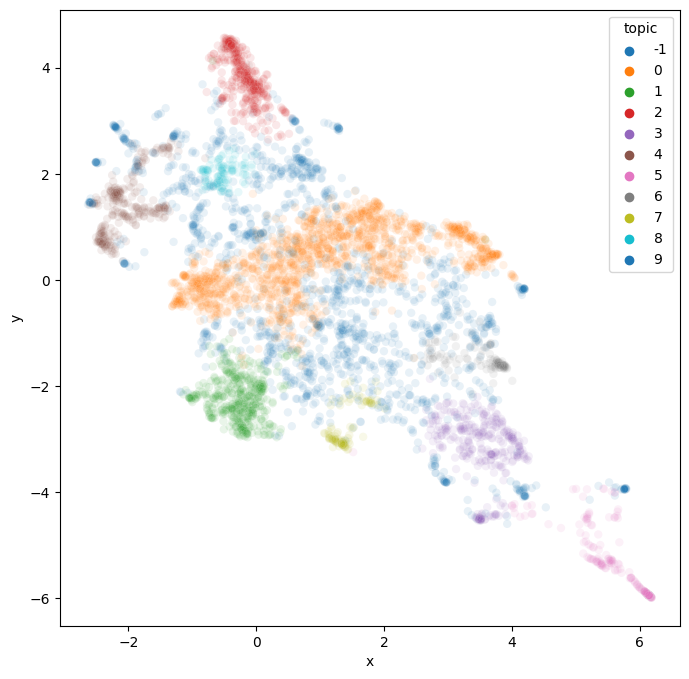

In [20]:
plt.figure(figsize=(8,8))
vis_df['topic'] = topics
sns.scatterplot(data=vis_df, x='x', y='y', hue='topic', palette='tab10', alpha=0.1)

This gives us some idea of the comments section, but we can do better. Instead of trying to guess what the major themes are in data based upon keywords, lets summarize the blocks of comments instead. To do this, we'll leverage a Large Language Model with prompting. It is at this point that we'll be leveraging [LangChain](https://python.langchain.com/en/latest/index.html) in order to create prompt templates and to abstract the prompts from the LLM, so that we can substitute in LLMs at will for any given prompting scheme.

In [21]:
prompt = '''These texts are comments made by various users to a U.S. Army Recruiting video. Please give a brief summarization of the comments as they relate to the video.'''

In [23]:
# Specify the LLM to use

#llm = OpenAI(temperature=0)
#llm = AzureOpenAI(deployment_name="gpt35", model_name="text-davinci-003")
llm = HuggingFacePipeline.from_model_id(model_id="declare-lab/flan-alpaca-gpt4-xl", task = 'text2text-generation', device=0,
                                      model_kwargs={"max_length":500, "no_repeat_ngram_size":2})

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [24]:
# Use the load_summarize_chain for the summarization task

chain = load_summarize_chain(llm, chain_type="stuff")

In [25]:
# Sepcify the topic modeling and summarization by a LangChain to an LLM

topic_model = BERTopic(
    embedding_model=embedding_model,
    umap_model = umap.UMAP(n_neighbors=30, n_components=50, min_dist=0.0, metric='cosine'),
    hdbscan_model = HDBSCAN(min_cluster_size=int(len(comments_df)/100), metric='euclidean', cluster_selection_method='eom', prediction_data=True),
    #nr_topics= "auto",
    representation_model = LangChain(chain, prompt=prompt)
)

In [26]:
topics, probs = topic_model.fit_transform(comments_df["clean_comment"])

Token indices sequence length is longer than the specified maximum sequence length for this model (1032 > 512). Running this sequence through the model will result in indexing errors


In [27]:
topic_model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,2058,-1_The tweets are from a user who claims that ...,[The tweets are from a user who claims that th...,[@RemotePlanet Treblinka doesn’t sound like an...
1,0,480,"0_The tweet is an open letter to the US Army, ...","[The tweet is an open letter to the US Army, e...",[You have no idea what you’re talking about. A...
2,1,454,1_The US Army is a land of opportunity for Isr...,[The US Army is a land of opportunity for Isra...,"[I will not die for Israel, I will die for Isr..."
3,2,413,2_The tweets discuss the negative experiences ...,[The tweets discuss the negative experiences o...,[@Maxwell.Vondeen no we’re not you got clowned...
4,3,286,3_The tweets are critical of Russia for its ac...,[The tweets are critical of Russia for its act...,"[@Ginger Licious and, yes, it’s not for you to..."
5,4,273,4_The comment section of the YouTube video is ...,[The comment section of the YouTube video is c...,[When you keep screaming from the rooftops tha...
6,5,254,"5_The protesters are chanting ""Shut it down, t...","[The protesters are chanting ""Shut it down, th...","[The goyim know.. SHUT IT DOWN!, OY VEY!! THE ..."
7,6,193,6_The author created a new army commercial fea...,[The author created a new army commercial feat...,[This is a good ad. I'm glad they went back to...
8,7,186,7_The tweet is a joke about zogbots.___,"[The tweet is a joke about zogbots., , , , , ,...","[zogbot, Zogbot, Zogbot lmao]"
9,8,132,8_The comment section is based and provides va...,[The comment section is based and provides val...,"[Based comment section, the comments 🤣🤣🤣🤣🤣, Th..."


In [118]:
for i in topic_model.get_topic_info()['Name']:
    print(i)

-1_The Army's diversity campaign is being criticized for sugar-coating the reality of military service and for promoting diversity instead of highlighting the challenges and dangers of combat.___
0_The comments discuss the lack of patriotism among members of the US military, particularly among younger generations. Some argue that the military should focus on its core values and not on political or ideological issues. Others argue for a stronger emphasis on the Army's history and tradition, and for the need to address concerns about recruitment.___
1_The US Army of Israel reassures its soldiers that they will not die for Israel, as it is a land of opportunity for the Jewish state.___
2_The tweets discuss the controversy surrounding the "woke" movement and its impact on society.___
3_The tweets discuss the role of Russia in the Holocaust and the denial of the existence of Nazism in Europe, the Middle East, and Africa.___
4_The Jewish community is urging the internet to shut down comments

In [28]:
rep_docs = topic_model.get_representative_docs()

In this first section, we know have an idea of what the general topics are for the discussion of the YouTube video. Through the use of pre-trained models, namely an LLM and a smaller sentence embedding  model, we were able to convert the text into vectors, cluster those vectors into 'topics' and then summarize the topics. 

# 5. Zero-shot Text Classification

Having summarized the comments to the YouTube video, we now want to classify these comments into some meaningful labels, based upon what types of comments we want to find and what kinds of comments likely exist in the data. To do this, we will once again use a no-train, pre-trained model combined with some free-text labels that we can specify; we are going to do a zero-shot text classification!

In [30]:
classifier = pipeline(model="facebook/bart-large-mnli", task="zero-shot-classification", device=0)

In [31]:
labels = ["supportive of service in the army", "antisemitic", "anti-ukraine", "anti-diversity", "anti-war", "anti-government", "white supremacy",
          "anti-immigration", "against service in the military", "arguing with someone", "anti-vaccination", "sexual misconduct", "neutral comment"]

In [32]:
# Screen for blank comments

comments_list = [i for i in comments_df['clean_comment'].to_list() if len(i) >0]

In [33]:
# Classify the actual comments

cls_results = classifier(comments_list, candidate_labels = labels, multi_label=True)

The previous set of blocks are all that is needed to do text classification, for any given set of labels we would like to apply to the text. No manual labeling required and labels can be mutli-word text strings themselves, which can help with more semantically nuanced labels 🙌

Now, lets look at the results

In [34]:
# look at some of the results

cls_results[0:3]

[{'sequence': "What will would come out with and say about the us army having contracts in relation to pathogen weapons with the Ukraine health system. The who said Ukraine health system has been under severe pressure. Pressure meaning to cause persuasion ob or intimidation. Now I've seen the leaked army document. I'm saving it to my phone. And I've sent the document to your presidents email.",
  'labels': ['anti-ukraine',
   'arguing with someone',
   'anti-government',
   'anti-war',
   'against service in the military',
   'supportive of service in the army',
   'anti-diversity',
   'antisemitic',
   'anti-vaccination',
   'white supremacy',
   'neutral comment',
   'anti-immigration',
   'sexual misconduct'],
  'scores': [0.21546143293380737,
   0.1712663173675537,
   0.16462503373622894,
   0.040081191807985306,
   0.01801249012351036,
   0.017138170078396797,
   0.013309652917087078,
   0.005149790085852146,
   0.004333734046667814,
   0.003373402403667569,
   0.00279589649289846

In [35]:
# Get out the most probable labels

zero_shot_labels = [res['labels'][np.argmax(res['scores'])] for res in cls_results]
label_counts = pd.DataFrame.from_dict(Counter(zero_shot_labels), orient='index', columns=['count'])
label_counts['label'] = label_counts.index

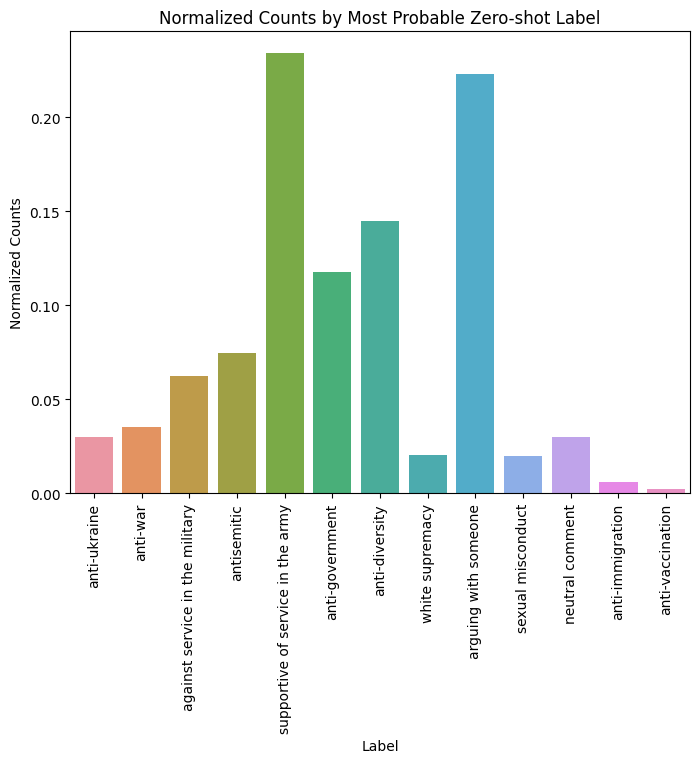

In [36]:
# Visualize the distribution of the most common labels in the comments

# Normalize the counts
label_counts['Normalized Counts'] = label_counts['count'] / label_counts['count'].sum()

# Create a bar plot using seaborn
plt.figure(figsize=(8, 6))
sns.barplot(data=label_counts, x='label', y='Normalized Counts')
plt.xlabel('Label')
plt.xticks(rotation=90)
plt.ylabel('Normalized Counts')
plt.title('Normalized Counts by Most Probable Zero-shot Label')
plt.show()

In [37]:
# Get the probable labels for each comment (each comment could have more than one probable label, or none)

threshold = 0.5
zero_shot_labels = [[res['labels'][i] for i in range(len(res['scores'])) if res['scores'][i] >=threshold] for res in cls_results]

# Create a set to store all unique strings in the sublists
unique_strings = set()
for sublist in zero_shot_labels:
    unique_strings.update(sublist)

# Initialize a dictionary to store the frequencies
frequencies = {string: [] for string in unique_strings}

# Count the occurrences of strings in each sublist
for sublist in zero_shot_labels:
    string_counts = {string: sublist.count(string) for string in unique_strings}
    for string, count in string_counts.items():
        frequencies[string].append(count)

# Create the dataframe
probable_labels_df = pd.DataFrame(frequencies)

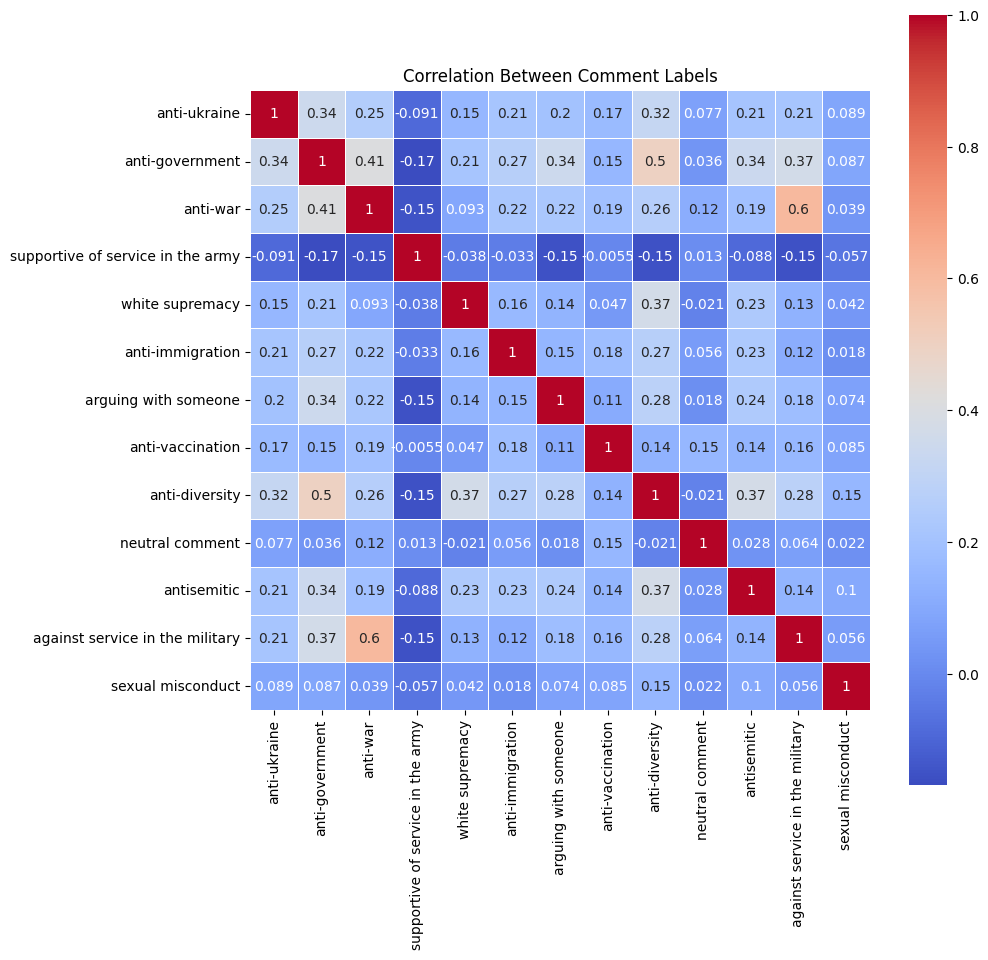

In [38]:
# Visualize the correlation between the different labels of the comments

# Calculate the point biserial correlation for each pair of columns
correlations = {}
for col1 in probable_labels_df.columns:
    for col2 in probable_labels_df.columns:
        if col1 != col2:
            corr, _ = stats.pointbiserialr(probable_labels_df[col1], probable_labels_df[col2])
            correlations[(col1, col2)] = corr

# Create a correlation matrix
corr_matrix = pd.DataFrame(index=probable_labels_df.columns, columns=probable_labels_df.columns)
for col1 in corr_matrix.columns:
    for col2 in corr_matrix.columns:
        corr_matrix.loc[col1, col2] = correlations.get((col1, col2), 1.0)


# Plot the correlation matrix as a heatmap
plt.figure(figsize=(10, 10))
sns.heatmap(corr_matrix.astype(float), annot=True, cmap='coolwarm', linewidths=0.5, square=True)
plt.title('Correlation Between Comment Labels')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()

explanation

# 6. Few-shot Prompting for Stance Classification

In [129]:
template = '''
comment: {comment}
stance: {stance}
'''

example_prompt = PromptTemplate(
    input_variables=["comment", "stance"],
    template=template
)

In [144]:
examples = [
    {'comment':rep_docs[0][2],
     'stance': 'AGAINST'},
    {'comment':rep_docs[1][1],
     'stance': 'AGAINST'},
    {'comment':rep_docs[2][2],
     'stance': 'NEUTRAL'},
    {'comment':rep_docs[4][0],
     'stance': 'AGAINST'},
    {'comment':rep_docs[6][0],
     'stance': 'FOR'}
]

In [145]:
print(example_prompt.format(**examples[0]))


comment: Hey Army, read the room. I've got a NCO buddy being asked "What can we do to improve recruiting numbers?"  What can he say? Nothing that you want to hear.   Many comments are about not wanting to fight/die for foreign/Israeli/politician wars.  Many comments are about not wanting to fight/die for a country that persecutes white males Many comments are about wokeness killing everything.  READ THE ROOM, ARMY! In 2007, your numbers were so bad you thought of reinstating the draft. I personally witnessed deceptive practices occurring then for recruiting such as providing black drill sgts "pimped out rides" to drive to show kids "You too can be gangsta" and other things like lowering standards, adjusting PT to accomodate unqualified and unfit, women for combat, etc. You have learned nothing, especially under Liberal "leadership" and college graduate "officers" leadership that we ALL KNOW "college isn't the home of patriotism".  "US Army... read the room". You want a suggestion? Her

In [153]:
prefix = """
The following are examples of the stance of a comment to a U.S. Army Recruiting Video on YouTube. Examples:
"""

suffix = '''
Now, classify each of the following comments into the possible stances of FOR, AGAINST, or NEUTRAL toward a U.S. Army Recruiting Video on YouTube. Only return the stance:

comment: {comment}
stance:
'''

few_shot_prompt_template = FewShotPromptTemplate(
    examples=examples,
    example_prompt=example_prompt,
    prefix=prefix,
    suffix=suffix,
    input_variables=["comment"],
    example_separator="\n"
)

In [154]:
print(few_shot_prompt_template.format(comment=comments_list[0]))


The following are examples of the stance of a comment to a U.S. Army Recruiting Video on YouTube. Examples:


comment: Hey Army, read the room. I've got a NCO buddy being asked "What can we do to improve recruiting numbers?"  What can he say? Nothing that you want to hear.   Many comments are about not wanting to fight/die for foreign/Israeli/politician wars.  Many comments are about not wanting to fight/die for a country that persecutes white males Many comments are about wokeness killing everything.  READ THE ROOM, ARMY! In 2007, your numbers were so bad you thought of reinstating the draft. I personally witnessed deceptive practices occurring then for recruiting such as providing black drill sgts "pimped out rides" to drive to show kids "You too can be gangsta" and other things like lowering standards, adjusting PT to accomodate unqualified and unfit, women for combat, etc. You have learned nothing, especially under Liberal "leadership" and college graduate "officers" leadership th

In [166]:
comments = np.random.choice(comments_list, size=20)

In [167]:
few_shot_stance_labels = [llm(few_shot_prompt_template.format(comment=x)) for x in comments]

In [168]:
sid = SentimentIntensityAnalyzer()

sentiment_labels = [sid.polarity_scores(x)['compound'] for x in comments]

In [171]:
stance_df = pd.DataFrame(zip(comments, few_shot_stance_labels, sentiment_labels), columns=['text', 'stance', 'sentiment'])

In [172]:
stance_df

,text,stance,sentiment
0,"If you truly are thinking about signing up, do...",AGAINST,0.2153
1,@Dr. Doolittle Confused about what? 39 replies...,NEUTRAL,-0.6774
2,"""America is a land of opportunity... for Israe...",NEUTRAL,0.3818
3,Hire the dude who made the PSYOP commerical,NEUTRAL,0.0000
4,"I'm not dying for Israel, Ukriane, or Taiwan. ...",AGAINST,0.0000
5,@Apocalypse Too bad the army ostracized their ...,AGAINST,-0.1779
6,I'm happy this slogan is back.... but we pay p...,NEUTRAL,-0.5267
7,"""Why are we not getting any new recruits?""",NEUTRAL,0.0000
8,"@Country Fried HVAC Yes, there were. Have you ...",NEUTRAL,0.7236
9,"Not anymore, be all you can be 🇺🇸🇺🇸🇺🇸",FOR,0.0000


In [180]:
stance_df.iloc[18,0]

"Support and defend degenerate politicians' over seas interests. Be all you can be for Washington D.C."

# Addendum

### Option 1

In [96]:
prompt = """
I have collection of YouTube comments to a U.S. Army Recruiting video that contains the following comments: \n[DOCUMENTS]
The collection is described by the following keywords: [KEYWORDS]

Based on the above information, can you give a brief descriprion of the collection?
"""

In [97]:
generator = pipeline(model="declare-lab/flan-alpaca-gpt4-xl", max_length=500, no_repeat_ngram_size=2, device=0)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [98]:
# Sepcify the topic modeling and summarization

topic_model = BERTopic(
    embedding_model=embedding_model,
    umap_model = umap.UMAP(n_neighbors=30, n_components=50, min_dist=0.0, metric='cosine'),
    hdbscan_model = HDBSCAN(min_cluster_size=int(len(comments_df)/100), metric='euclidean', cluster_selection_method='eom', prediction_data=True),
    #nr_topics= "auto",
    representation_model = [MaximalMarginalRelevance(diversity=0.3), TextGeneration(generator, prompt=prompt)]
)

In [99]:
topics, probs = topic_model.fit_transform(comments_df["clean_comment"])

In [100]:
topic_model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,1578,-1_The collection of YouTube comments is a res...,[The collection of YouTube comments is a respo...,[@SEnergy Except the US didn't annex any of th...
1,0,1121,0_The collection of YouTube comments is a resp...,[The collection of YouTube comments is a respo...,"[""BE ALL YOU CAN BE"" was, is and always will b..."
2,1,446,1_The collection of YouTube comments is a resp...,[The collection of YouTube comments is a respo...,"[I will not die for Israel, I will die for Isr..."
3,2,421,2_The collection of YouTube comments is a resp...,[The collection of YouTube comments is a respo...,"[@The Gem don't do it man, everyone I know wh..."
4,3,326,3_The collection of YouTube comments is a resp...,[The collection of YouTube comments is a respo...,[They hate your for being White but they want ...
5,4,314,4_The collection of YouTube comments discusses...,[The collection of YouTube comments discusses ...,[@Андрей Власов Neat. How does that justify Ru...
6,5,241,5_The collection of YouTube comments contains ...,[The collection of YouTube comments contains o...,"[Shut it down THE GOYIM KNOW, Oy Vey! the Goyi..."
7,6,165,6_The collection of YouTube comments contains ...,[The collection of YouTube comments contains j...,"[Zogbot, zogbot, Zogbot lmao]"
8,7,135,7_The collection of YouTube comments is relate...,[The collection of YouTube comments is related...,"[These comments are so based., Based comment s..."
9,8,104,8_The collection of YouTube comments contains ...,[The collection of YouTube comments contains m...,"[Be All You Can Be!, Be all you can be., Be al..."


In [101]:
for i in topic_model.get_topic_info()['Name']:
    print(i)

-1_The collection of YouTube comments is a response to 'This was so gay.', expressing disapproval towards the use of the word woke in the video. The comments also discuss the reality of being in an Army, which is not always clean and involves struggles and death.___
0_The collection of YouTube comments is a response to promoting the U.S. Army's recruitment video. Some of the comments are critical of its message, highlighting the sacrifice of Marines who died in combat. Others praise the Army for its slogan, "BE ALL YOU CAN BE," and compare the previous "WOKE" commercial to an embarrassment. The last comment, which references Soros and the WEF, suggests that surviving the military is an act of betrayal of one'' country. Overall, the collection expresses varying opinions on the effectiveness of Army recruitment efforts and their potential to promote patriotism and unity.___
1_The collection of YouTube comments is a response to 'Be All You Can Be (For Israel)', referring to the U.S. Army 

### Option 2

In [108]:
prompt = '''These texts are comments about a U.S. Army Recruiting video. What is the theme of these comments? Please give a brief description.'''

In [103]:
# llm = OpenAI(temperature=0)
llm = HuggingFacePipeline.from_model_id(model_id="declare-lab/flan-alpaca-gpt4-xl", task = 'text2text-generation', device=0,
                                       model_kwargs={"max_length":500, "no_repeat_ngram_size":2})

chain = load_qa_chain(llm=llm, chain_type="stuff")

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [109]:
# Sepcify the topic modeling and summarization

topic_model = BERTopic(
    embedding_model=embedding_model,
    umap_model = umap.UMAP(n_neighbors=30, n_components=50, min_dist=0.0, metric='cosine'),
    hdbscan_model = HDBSCAN(min_cluster_size=int(len(comments_df)/100), metric='euclidean', cluster_selection_method='eom', prediction_data=True),
    #nr_topics= "auto",
    representation_model = LangChain(chain, prompt=prompt)
)

In [110]:
topics, probs = topic_model.fit_transform(comments_df["clean_comment"])

In [111]:
topic_model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,1610,-1_The theme of these comments is the U.S. Arm...,[The theme of these comments is the U.S. Army ...,[​​​@Justin Williams I get where you're coming...
1,0,1161,0_The theme of these comments is disapproval a...,[The theme of these comments is disapproval an...,"[So they remove ""that"" It used to be: Be, all..."
2,1,455,1_The theme of these comments is support for t...,[The theme of these comments is support for th...,"[I will not die for Israel, I will not die for..."
3,2,407,2_The theme of these comments is disapproval a...,[The theme of these comments is disapproval an...,"[@The Gem don't do it man, everyone I know wh..."
4,3,374,3_The theme of these comments is anti-military...,[The theme of these comments is anti-military ...,[It's in jest. The US Army is trying to pull ...
5,4,284,4_The theme of these comments is anti-Russian ...,[The theme of these comments is anti-Russian s...,[​​@I Stand With Russia (Z O V) Do you actuall...
6,5,244,5_The theme of these comments is anti-Semitism...,[The theme of these comments is anti-Semitism ...,"[The goyim know, shut it down., Oy Vey! the Go..."
7,6,161,6_The theme of these comments is humor and sup...,[The theme of these comments is humor and supp...,"[Zogbot, Zogbot, Zogbot lmao]"
8,7,109,7_The theme of these comments is helpful.___,"[The theme of these comments is helpful., , , ...","[These comments are so based., Based comment s..."
9,8,106,"8_The theme of these comments is ""Believe in y...","[The theme of these comments is ""Believe in yo...","[Be all you can be., Be All You Can Be!, Be al..."


In [112]:
for i in topic_model.get_topic_info()['Name']:
    print(i)

-1_The theme of these comments is the U.S. Army Recruiting video.___
0_The theme of these comments is disapproval and rejection of the U.S. Army's recruitment efforts.___
1_The theme of these comments is support for the U.S. Army and its mission to protect and defend Israel.___
2_The theme of these comments is disapproval and criticism of the U.S. Army Recruiting video.___
3_The theme of these comments is anti-military recruitment and the exodus of white males from the U.S. Army.___
4_The theme of these comments is anti-Russian sentiment and antisemitism.___
5_The theme of these comments is anti-Semitism and antipathy towards the Jewish community.___
6_The theme of these comments is humor and support for the U.S. Army Recruiting video.___
7_The theme of these comments is helpful.___
8_The theme of these comments is "Believe in yourself and your abilities."___
9_The theme of these comments is anti-government and anti Trump protests.___
10_The theme of these comments is criticism of the 